In [1]:
print(__doc__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.metrics import accuracy_score,roc_curve,auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from scipy import interp

%matplotlib notebook

Automatically created module for IPython interactive environment


In [2]:
def make_meshgrid(x,y,h=0.2):
    """
    create a mesh of points to plot in
    h: int, step-size
    """
    x_min, x_max = x.min() - 1, x.max() - 1
    y_min, y_max = y.min() - 1, y.max() - 1
    xx,yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
    return xx,yy
def plot_contours(ax, clf, xx, yy, **params):
    """
    Plot the decision boundaries for a classifier.
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [5]:
iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

### Model


In [7]:
C = 1.0      #regularization param
models = (svm.SVC(kernel='linear',C = C),
          svm.LinearSVC(C=C, max_iter = 10000),
          svm.SVC(kernel = 'rbf',gamma = 0.7, C = C),
          svm.SVC(kernel = 'poly',degree=3, gamma='auto', C = C),
         xgb.XGBClassifier(booster='gblinear',alpha =0.1),
         )
models = (clf.fit(X_train, y_train) for clf in models)

In [8]:
def get_result(xtest, ytest, model):

    for clf in model:
        y_predicted = clf.predict(xtest)
        score = accuracy_score(ytest,y_predicted)
        print(score)

get_result(X_test,y_test,models)

0.8
0.6888888888888889
0.7777777777777778
0.7777777777777778
0.5111111111111111


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [2]:
from sklearn import tree
import pydotplus
from IPython.display import Image
import graphviz

In [6]:
dtree = tree.DecisionTreeClassifier(max_depth =5,criterion='entropy')
dtree = dtree.fit(iris.data,iris.target)

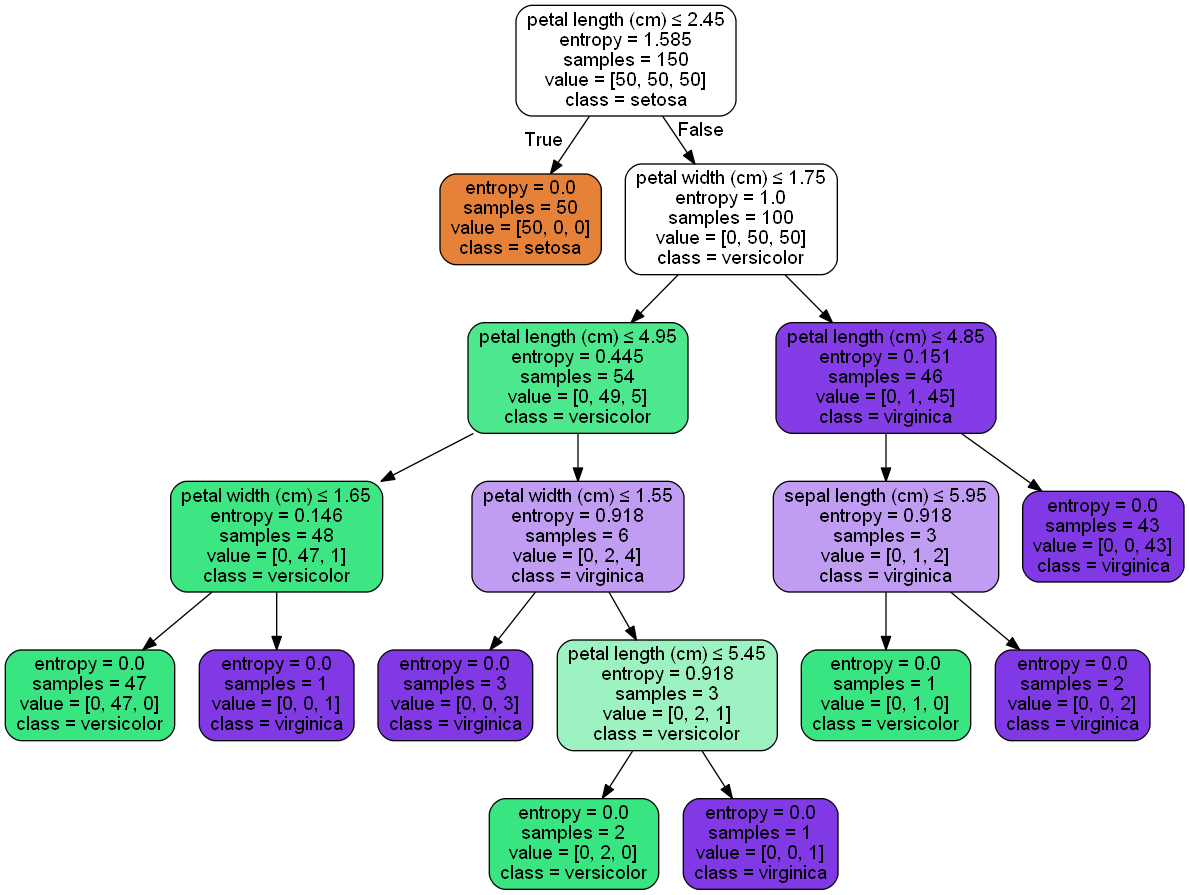

In [7]:
dot_data = tree.export_graphviz(dtree,out_file= None,feature_names = iris.feature_names,
                            class_names = iris.target_names,filled = True,
                               rounded = True,
                                special_characters=True)
graph0 = pydotplus.graph_from_dot_data(dot_data)
Image(graph0.create_png())

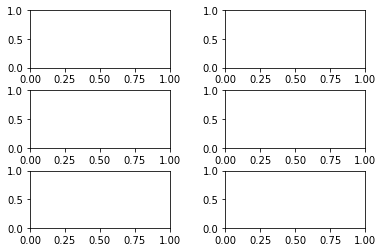

In [9]:
# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel',
         'xgboost with gblinear')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

In [75]:
plt.savefig('plot.png')

In [9]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train,y_train).predict(X_test)
y_pred

array([1, 1, 0, 2, 0, 2, 0, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0,
       0])

In [10]:
score = accuracy_score(y_test,y_pred)
score

0.8

In [11]:
# Add noisy features

X = iris.data[:,:2]
y = iris.target
X, y = X[y != 2], y[y != 2]


n_samples, n_features = X.shape
random_state = np.random.RandomState(0)
X = np.c_[X,random_state.randn(n_samples,200*n_features)]

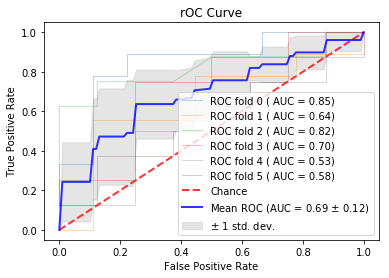

In [18]:
# #############################################################################
# Classification and ROC analysis

cv = StratifiedKFold(n_splits=6)
Classifier = svm.SVC(kernel = 'linear', probability = True, random_state = random_state)
tprs=[]
aucs=[]
mean_fpr = np.linspace(0,1,100)

i = 0
for train,test in cv.split(X,y):
    probas_ = Classifier.fit(X[train],y[train]).predict_proba(X[test])
    # compute ROC curve and area under the curve
    fpr, tpr,thresholds = roc_curve(y[test],probas_[:,1])
    tprs.append(interp(mean_fpr,fpr,tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    plt.plot(fpr,tpr,lw=1,alpha = 0.3,
                 label = 'ROC fold %d ( AUC = %0.2f)'%(i,roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('rOC Curve')
plt.legend(loc="lower right")
plt.savefig('ROC-AUC_curve')
plt.show()